In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cppbridge import *

In [2]:
%load_ext autoreload
%autoreload 2

# Checking Metropolitan and EHMM samplers with non-linear non-Gaussian models

The experiments are for the models and samplers presented in the paper\
[1] Shestopaloff A.Y, Neal R.M. Sampling Latent States for High-Dimensional Non-Linear State Space Models with the Embedded HMM Method

---
## Model specification

### Transition model  
For transition model we take the same AR(1) model as with linear gaussian experiments.

### Observation models
We will be using two observation models, both following Poisson distribution.

The first model is defined as follows:
$$\mathbf{Y}_{t,i}|x_{t,i}\sim Poiss(exp(c_{i}+\sigma_{i} x_{t,i})),\  t=1,...,T,\ i=1,...,n$$
This is a multivariate generalised linear Poisson model with mean function $e^{\mathbf{\theta}}$ and zero covariance. We will specify the natural parameter $\mathbf{\theta}$ in terms of linear operators $\mathbf{\theta}_{t}=\mathbf{C}\mathbf{x}_{t}+\mathbf{D}\mathbf{u}$, where $\mathbf{C}$ is a diagonal param with $C_{i,i}=\sigma_{i}$, $\mathbf{D}$ is a diagonal param with $D_{i,i}=c_{i}$ and $\mathbf{u}$ is a vector of all ones.

And the second model:
$$\mathbf{Y}_{t,i}|x_{t,i}\sim Poiss(\sigma_{i} |x_{t,i}|),\  t=1,...,T,\ i=1,...,n$$


As before, the dimension of the observation is the same as for the latent state, and we assume each dimension is indpendent from the other.

For the experiements below with the first model we use 10-dimensional latent state, with sequence length $T=250$, and the parameter values as follows:\
$n=10, a_{i}=0.9\text{ for }i=1\ldots n,\text{ and }\rho=0.7$ The observation model parameters are $c_{i}=-0.4\text{ and }\sigma_{i}=0.6$.

For the second model we use use 15-dimensional latent state, with sequence length $T=500$, and same transition model parameters and the observation model parameter set at $\sigma=0.8$.

#### Model 1 

In [5]:
# Set up the transition model with parameters above
T_1 = 250
n_1 = 10
A = np.eye(n_1) * 0.9
Q = np.ones((n_1,n_1)) * 0.7 + np.eye(n_1) * 0.3
prior_mean = np.zeros(n_1)
Q_init = Q * (1/(1-0.9*0.9))
trm_1 = TransitionSpec(A, Q, prior_mean, Q_init)

In [78]:
# Set up the observation model 1
C = np.eye(n_1) - 1.4 * np.eye(n_1)
Sigma = 0.6 * np.eye(n_1)  
ctrls = np.ones(n_1)
obsm_1 = ObservationSpec(ModelType.LINEAR_POISSON, Sigma, C, ctrls)

#### Model 2

In [8]:
# Set up the transition model with parameters above
T_2 = 500
n_2 = 15
A_2 = np.eye(n_2) * 0.9
Q_2 = np.ones((n_2,n_2)) * 0.7 + np.eye(n_2) * 0.3
prior_mean_2 = np.zeros(n_2)
Q_init_2 = Q * (1/(1-0.9*0.9))
trm_2 = TransitionSpec(A_2, Q_2, prior_mean_2, Q_init_2)

In [83]:
# Set up the observation model 2
Sigma_2 = 0.8 * np.eye(n_2)  
obsm_2 = ObservationSpec(ModelType.BIMODAL_POISSON, Sigma_2)

## Sampler specification  

As with linear models we check the two sampling shcemes to sample from the distribution of the latent states: Metropolis single state update, and embedded EHMM method, described in [1].

### Metropolis sampling scheme
The scheme samples one state at a time, with all dimensions at once, conditional on all other states $x_{-t}=(x_{1},...,x_{t-1},x_{t+1},...,x_{n})$, using autoregressive update of the form described in [1].

In [15]:
# Specify metropolis scheme
met_sampler = SamplerSpec(SamplerType.METROPOLIS)

\
To run the simulation we need to provide the initial sample $\mathbf{x}_0$ to start off the sampler, and specify the parameters of the simulation. We set $\mathbf{x}_0=\mathbf{0}$ for this scheme and model 1, and $\mathbf{x}_0=\mathbf{1}$ for model 2. We run 5 simulations for $10^6$ iterations each, starting with the different seed for randomisation. To save memory we thin the sampling, only recording each tenth sample.

In [9]:
n_iter_met = int(1e6)
seeds = np.array([1, 10, 100, 1e4, 1e5], dtype=int)  # <-- pass empty array, and add smoother spec to MCMC session, to run only Kalman smoother
scales_met = np.array([0.2, 0.8])
thinning = 10

# Simulation spec for Model 1 
x_init_1 = np.zeros((n_1, T_1))
simulation_met_1 = SimulationSpec(n_iter_met, seeds, x_init_1, thinning, scales_met)

# Simulation for Model 2
x_init_2 = np.ones((n_2, T_2))
simulation_met_2 = SimulationSpec(n_iter_met, seeds, x_init_2, thinning, scales_met)

### Embedded HMM sampling scheme
This scheme was proposed in [1] and uses forward pool state selection. Each sampling step samples the whole sequence at once, using HMM forwards/backwards-like algorithm to select a state from the pool at each time. To generate the pool for each time the scheme uses autoregressive and shift updates. If specified it can alternate between updates on original and the reversed observations sequence. 

In [18]:
# Specify EHMM schemes for both models
pool_sz_1 = 50
ehmm_sampler_1 = SamplerSpec(SamplerType.EHMM, pool_sz_1)
pool_sz_2 = 80
ehmm_sampler_2 = SamplerSpec(SamplerType.EHMM, pool_sz_2)

\
As with the seingle state sampler, we set $\mathbf{x}_0=\mathbf{0}$ for this scheme and model 1, and $\mathbf{x}_{0}=\mathbf{1}$ for model 2. We run 5 simulations for $10000$ iterations each, starting with the different seed for randomisation (we use the same seeds as for single state sampler). Each iteration will run on both original and reversed sequence of observations.

In [19]:
n_iter_ehmm = 10000
scales_ehmm = np.array([0.1, 0.4])
reverse = True
simulation_ehmm_1 = SimulationSpec(n_iter_ehmm, seeds, x_init_1, scaling=scales_ehmm, reverse=reverse)
simulation_ehmm_2 = SimulationSpec(n_iter_ehmm, seeds, x_init_2, scaling=scales_ehmm, reverse=reverse)

## Observations 
Finally, we need the observations, on which to run the samplers and the smoother. The data we use is the synthetic data, generated by the programme using the parameters of the models we specified. To control the output we provide teh seed for data generator.

## Simulation    
At first we run the Metropolitan single state sampler and compare the results with the Kalman smoother results. This will establish a benchmark for further experiments. We will also run the EHMM sampler and compre its results with our benchmark as well as with the single state sampler.

## Simulation for model 1

In [3]:
# Simulation with Metropolitan single state sampler and model 1
met_session_name_1 = "met_poiss1_noreverse"
mcmc_met_lg_1 = MCMCsession(met_session_name_1)
if mcmc_met_lg_1.hasResults():
    mcmc_met_lg_1.loadResults() # <-- NB! Each file is ~2GB so it takes time to download
else:
    mcmc_met_lg_1.setData(T_1, trm_1, obsm_1, met_sampler, simulation_met_1, dataspec)
    mcmc_met_lg_1.run()

Loading results for seed100000...		Done
Loading results for seed10000...		Done
Loading results for seed100...		Done
Loading results for seed1...		Done
Loading results for seed10...		Done


In [87]:
# Simulation with EHMM sampler
ehmm_session_name = "ehmm50_noflip_gauss_wreverse"
mcmc_ehmm_lg = MCMCsession(ehmm_session_name)
if mcmc_ehmm_lg.hasResults():
    mcmc_ehmm_lg.loadResults()
else:
    mcmc_ehmm_lg.setData(T, trm, obsm, ehmm_sampler, simulation_ehmm, dataspec)
    mcmc_ehmm_lg.run()

Loading results for seed1...		Done
Loading results for seed10...		Done
Loading results for seed10000...		Done
Loading results for seed100000...		Done
Loading results for seed100...		Done


---
## Analysis of the results for model 1

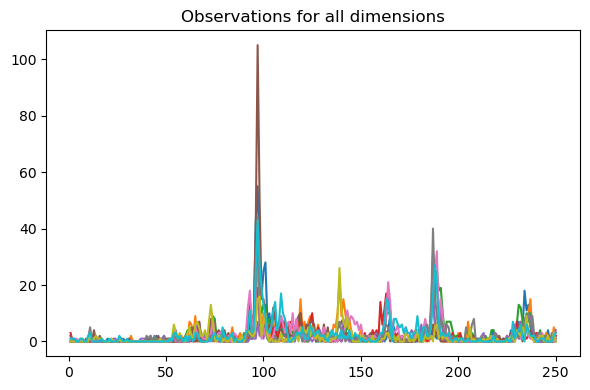

In [85]:
# Plot the observations for all dimenstions across time
fig, ax = plt.subplots(figsize=(6,4))
xs = np.array(range(1, T_1+1))
for i in range(n_1):
    ax.plot(xs, mcmc_met_lg_1.data[:,i])
ax.set_title("Observations for all dimensions")
plt.tight_layout()
plt.show();
# TODO: 
# - make lines lighter 
# - highlight the same dimenstion with the same colour 
# - make possible to highilght some dimensions and dim others 

In [10]:
# Show the average means from 5 runs of metropolis sampler
samples_means = {}
all_seeds_means = np.zeros((T_1, n_1))
burnin = int(0.1 * (n_iter_met/thinning + 1))

for seed, sample in mcmc_met_lg_1.samples.items():
    samples_means[seed] = np.mean(sample[burnin:], axis=0)
    all_seeds_means += samples_means[seed]

all_seeds_means /= seeds.size

In [14]:
met_means = pd.DataFrame({f"seed{seed}":samples_means[f'seed{seed}'][95] for seed in seeds})\
            .join(pd.DataFrame({"total_mean": all_seeds_means[95]}))
met_means

,seed1,seed10,seed100,seed10000,seed100000,total_mean
0,6.603935,6.605813,6.602848,6.603103,6.603278,6.603795
1,5.291354,5.283714,5.296225,5.294038,5.293035,5.291673
2,5.038074,5.042438,5.037791,5.042304,5.040607,5.040243
3,4.241011,4.245972,4.241744,4.236065,4.231934,4.239345
4,2.255702,2.253781,2.260981,2.256783,2.274792,2.260408
5,6.771854,6.771964,6.771163,6.769383,6.773324,6.771538
6,5.021029,5.028775,5.025655,5.032316,5.025238,5.026603
7,5.258405,5.259966,5.261739,5.258378,5.259864,5.259670
8,3.951387,3.944857,3.946027,3.951829,3.957513,3.950323
9,5.848253,5.845480,5.840706,5.844474,5.849907,5.845764


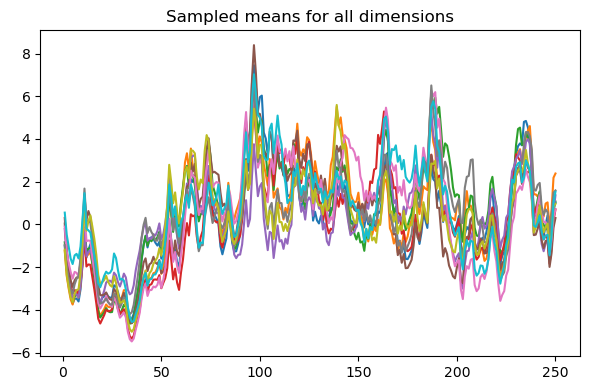

In [17]:
# Sampled means
fig, ax = plt.subplots(figsize=(6,4))
xs = np.array(range(1, T_1+1))
for i in range(n_1):
    ax.plot(xs, all_seeds_means[:,i])
ax.set_title("Sampled means for all dimensions")
plt.tight_layout()
plt.show();
# TODO: plot relationship between states and observations 

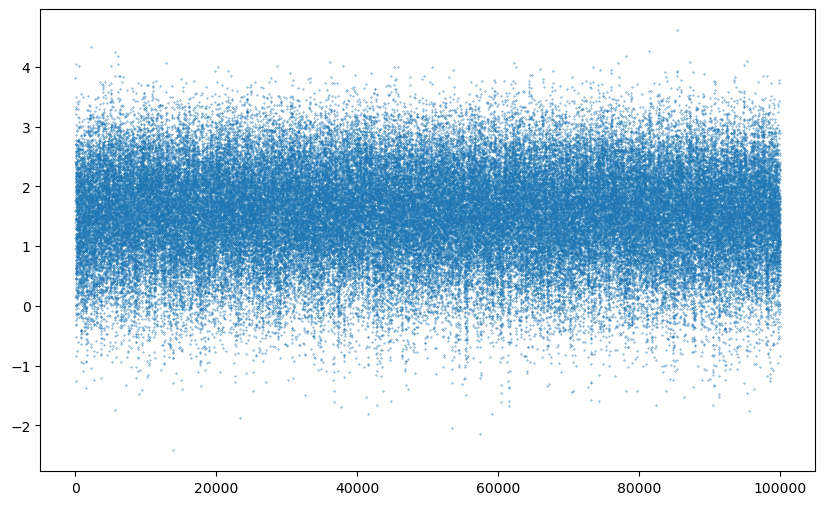

In [106]:
fig, ax = plt.subplots(figsize=(10,6))
xs = np.array(range(int(n_iter_met/thinning + 1)))+1
ax.scatter(xs, mcmc_met_lg_1.samples['seed100'][:,249,9], s=0.1)
plt.show();

In [88]:
# Compare the smoothed means with average means from 5 runs of EHMM sampler
ehm_samples_means = {}
ehm_all_seeds_means = np.zeros((T, n))
ehm_burnin = int(0.1 * 2 * (n_iter_ehmm + 1)) # <-- as we run on reversed sequence, too, there will be twice as many samples

for seed, sample in mcmc_ehmm_lg.samples.items():
    ehm_samples_means[seed] = np.mean(sample[ehm_burnin:], axis=0)
    ehm_all_seeds_means += ehm_samples_means[seed]

ehm_all_seeds_means /= seeds.size

In [89]:
ehm_means = pd.DataFrame({f"seed{seed}":ehm_samples_means[f'seed{seed}'][-1] for seed in seeds})\
            .join(pd.DataFrame({"total_mean": ehm_all_seeds_means[-1], "kalman":smoother_results.means[-1]}))
ehm_means["diff"] = abs(np.log(abs(ehm_means["total_mean"])) - np.log(abs(ehm_means["kalman"])))
ehm_means

,seed1,seed10,seed100,seed10000,seed100000,total_mean,kalman,diff
0,0.177680,0.124188,0.149665,0.127494,0.147169,0.145239,0.152385,0.048030
1,0.371460,0.390293,0.384515,0.395230,0.402346,0.388769,0.390795,0.005198
2,0.307927,0.348749,0.311227,0.317458,0.311065,0.319285,0.319107,0.000559
3,-0.942519,-0.930226,-0.929397,-0.916905,-0.962855,-0.936380,-0.933533,0.003045
4,0.110982,0.144388,0.139852,0.129434,0.103404,0.125612,0.115583,0.083210
5,-0.485671,-0.482531,-0.465232,-0.432615,-0.483386,-0.469887,-0.477413,0.015889
6,0.943105,0.924004,0.939866,0.923208,0.913302,0.928697,0.923921,0.005156
7,-0.082557,-0.086246,-0.094786,-0.065471,-0.049550,-0.075722,-0.078499,0.036016
8,0.343600,0.347862,0.379111,0.325087,0.332511,0.345634,0.337072,0.025083
9,-0.215082,-0.157050,-0.148361,-0.194599,-0.178555,-0.178729,-0.182339,0.019996


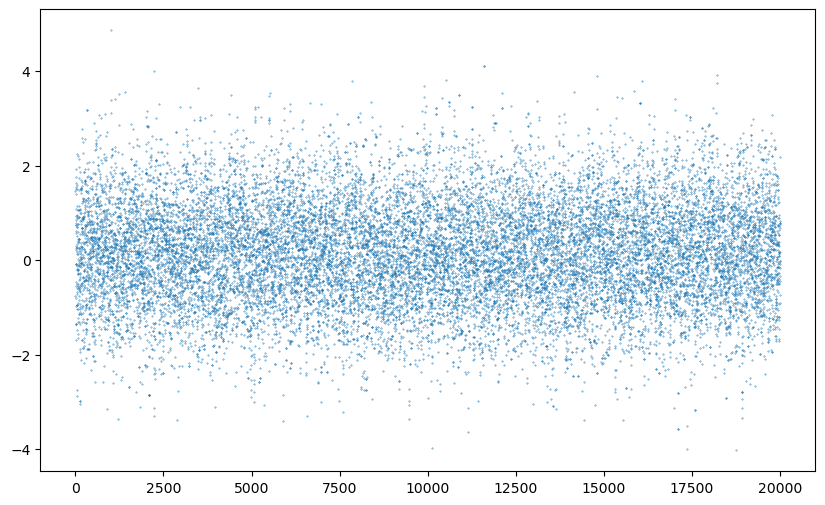

In [56]:
fig, ax = plt.subplots(figsize=(10,6))
ehm_xs = np.array(range(2*(n_iter_ehmm + 1)))+1
ax.scatter(ehm_xs, mcmc_ehmm_lg.samples['seed100'][:,249,0], s=0.1)
plt.show();